In [ ]:
!pip install numpy -q
!pip install pandas -q
!pip install tqdm -q
!pip install scikit-learn -q
!pip install catboost -q
!pip install seaborn -q

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 200)

### Baseline

In [3]:
X_train_dataset = pd.read_csv("X.csv")
y_train_dataset = pd.read_csv("y.csv")

In [8]:
df = pd.merge(X_train_dataset, y_train_dataset, on=["engine_id", "flight_datetime", "flight_phase"])

meta_columns = [
  "engine_id", "aircraft_id", "flight_datetime",
  "flight_phase", "engine_family", "engine_type", "manufacturer",
  "aircraft_family", "aircraft_type", "aircraft_grp", "ac_manufacturer"
]

In [9]:
def get_score_by_parameter(predict_field):
    df = pd.merge(X_train_dataset, y_train_dataset, on=["engine_id", "flight_datetime", "flight_phase"])
    df = df[df[predict_field].notna()]
    df = df.fillna(-100)
    X = df.drop(columns=[predict_field])
    X = X.drop(columns=meta_columns)
    y = df[predict_field]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    model = CatBoostRegressor(iterations=200, verbose=False)
    model.fit(X_train, y_train)
    catboost_predicted = model.predict(X_test)
    catboost_score = mean_squared_error(y_test, catboost_predicted, squared=False)
    catboost_predicted = model.predict(X)
    return catboost_score

In [10]:
scores = pd.DataFrame(columns=["parameter", "rmse", ".0", ".1", ".5", ".9", "1"])
output_parameters = y_train_dataset.columns.drop(['flight_datetime', 'flight_phase', 'engine_id'])

for param in tqdm(output_parameters):
    try:
        score = get_score_by_parameter(param)
        qua = df[param].quantile([.0, .1, .5, .9, 1])
        qua = list(qua)
        scores.loc[len(scores)] = [param, score] + qua
    except:
        continue

100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


In [11]:
scores

,parameter,rmse,.0,.1,.5,.9,1
0,BRAT,0.005009,0.000000,0.868485,1.000000,1.000000,1.954098
1,DEGT,2.085398,-184.170715,-27.160400,6.281616,30.211646,80.758423
2,DELFN,0.157159,-3.178211,9.006846,15.801858,26.496931,39.112564
3,DELN1,0.109561,-1.588493,3.747295,6.333039,10.703587,17.277214
4,DELVSV,0.035319,-0.800000,1.300000,2.300000,3.300000,18.200001
5,DPOIL,0.089729,-31.672470,-24.614487,-20.672855,-12.408699,2.366665
6,EGTC,1.455071,479.787018,594.069019,644.083496,760.351026,889.812988
7,EGTHDM,0.848119,-55.431641,19.796198,52.873406,73.615068,286.805603
8,EGTHDM_D,0.188952,-34.172806,-10.467921,0.000000,10.467924,34.172810
9,GEGTMC,0.962774,8.715698,52.337040,79.473602,141.741243,298.171021


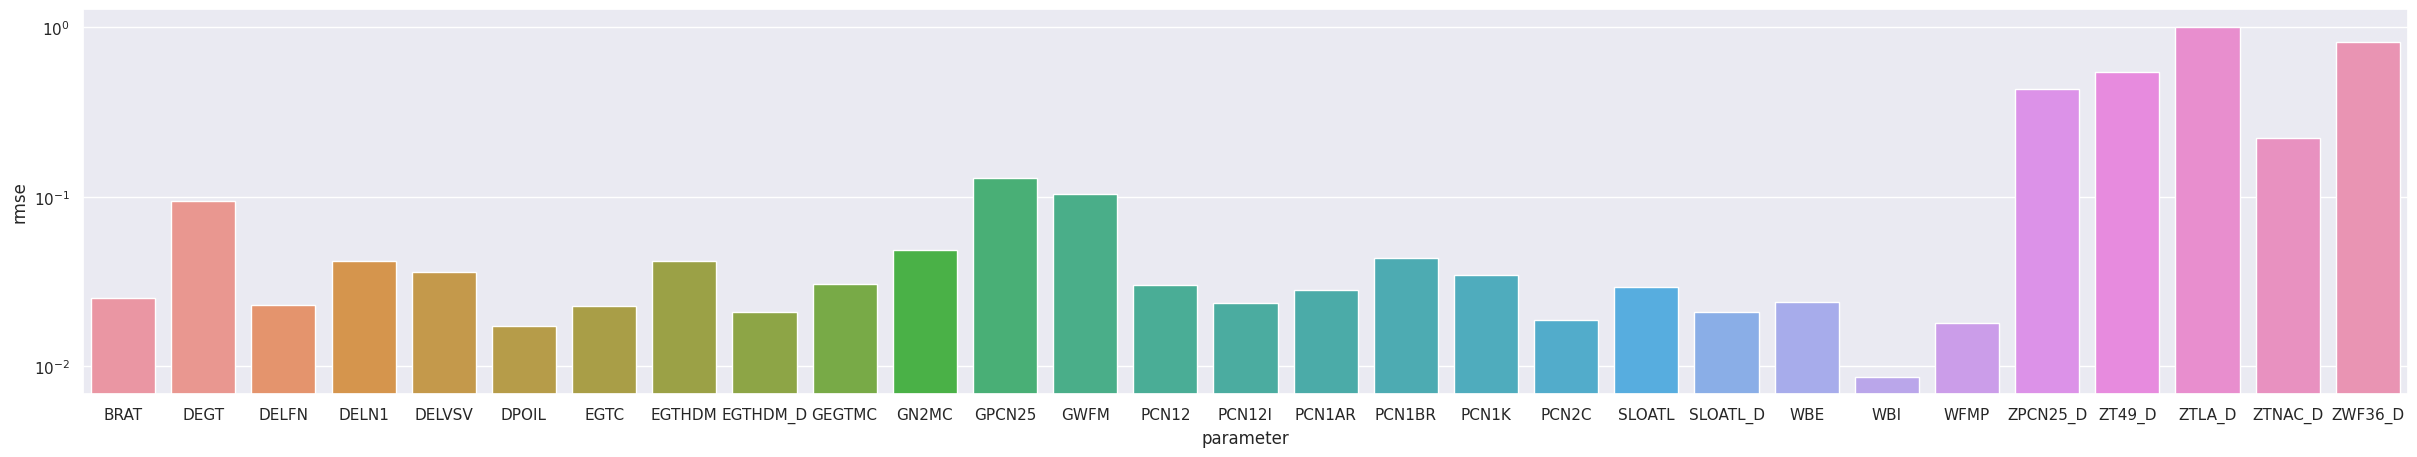

In [18]:
sns.set(rc={'figure.figsize':(30,5)})

p = sns.barplot(scores, y='rmse', x='parameter')
p.set_yscale("log")

### Normalization

In [13]:
def get_score_by_parameter_norm(predict_field):
    df = pd.merge(X_train_dataset, y_train_dataset, on=["engine_id", "flight_datetime", "flight_phase"])
    df = df[df[predict_field].notna()]
    df = df.fillna(-100)
    X = df.drop(columns=[predict_field])
    X = X.drop(columns=meta_columns)
    y = df[predict_field]

    X_norm = (X - X.mean()) / X.std()
    y_norm = (y - y.mean()) / y.std()
    
    X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.33, random_state=42)
    
    model = CatBoostRegressor(iterations=200, verbose=False)
    model.fit(X_train, y_train)
    catboost_predicted = model.predict(X_test)
    catboost_score = mean_squared_error(y_test, catboost_predicted, squared=False)
    catboost_predicted = model.predict(X)
    return catboost_score

In [14]:
scores = pd.DataFrame(columns=["parameter", "rmse", ".0", ".1", ".5", ".9", "1"])
output_parameters = y_train_dataset.columns.drop(['flight_datetime', 'flight_phase', 'engine_id'])

for param in tqdm(output_parameters):
    try:
        score = get_score_by_parameter_norm(param)
        qua = df[param].quantile([.0, .1, .5, .9, 1])
        qua = list(qua)
        scores.loc[len(scores)] = [param, score] + qua
    except:
        continue

100%|██████████| 30/30 [00:18<00:00,  1.64it/s]


In [15]:
scores

,parameter,rmse,.0,.1,.5,.9,1
0,BRAT,0.025293,0.000000,0.868485,1.000000,1.000000,1.954098
1,DEGT,0.094530,-184.170715,-27.160400,6.281616,30.211646,80.758423
2,DELFN,0.023011,-3.178211,9.006846,15.801858,26.496931,39.112564
3,DELN1,0.041936,-1.588493,3.747295,6.333039,10.703587,17.277214
4,DELVSV,0.035803,-0.800000,1.300000,2.300000,3.300000,18.200001
5,DPOIL,0.017296,-31.672470,-24.614487,-20.672855,-12.408699,2.366665
6,EGTC,0.022647,479.787018,594.069019,644.083496,760.351026,889.812988
7,EGTHDM,0.041690,-55.431641,19.796198,52.873406,73.615068,286.805603
8,EGTHDM_D,0.020921,-34.172806,-10.467921,0.000000,10.467924,34.172810
9,GEGTMC,0.030627,8.715698,52.337040,79.473602,141.741243,298.171021


<Axes: xlabel='parameter', ylabel='rmse'>

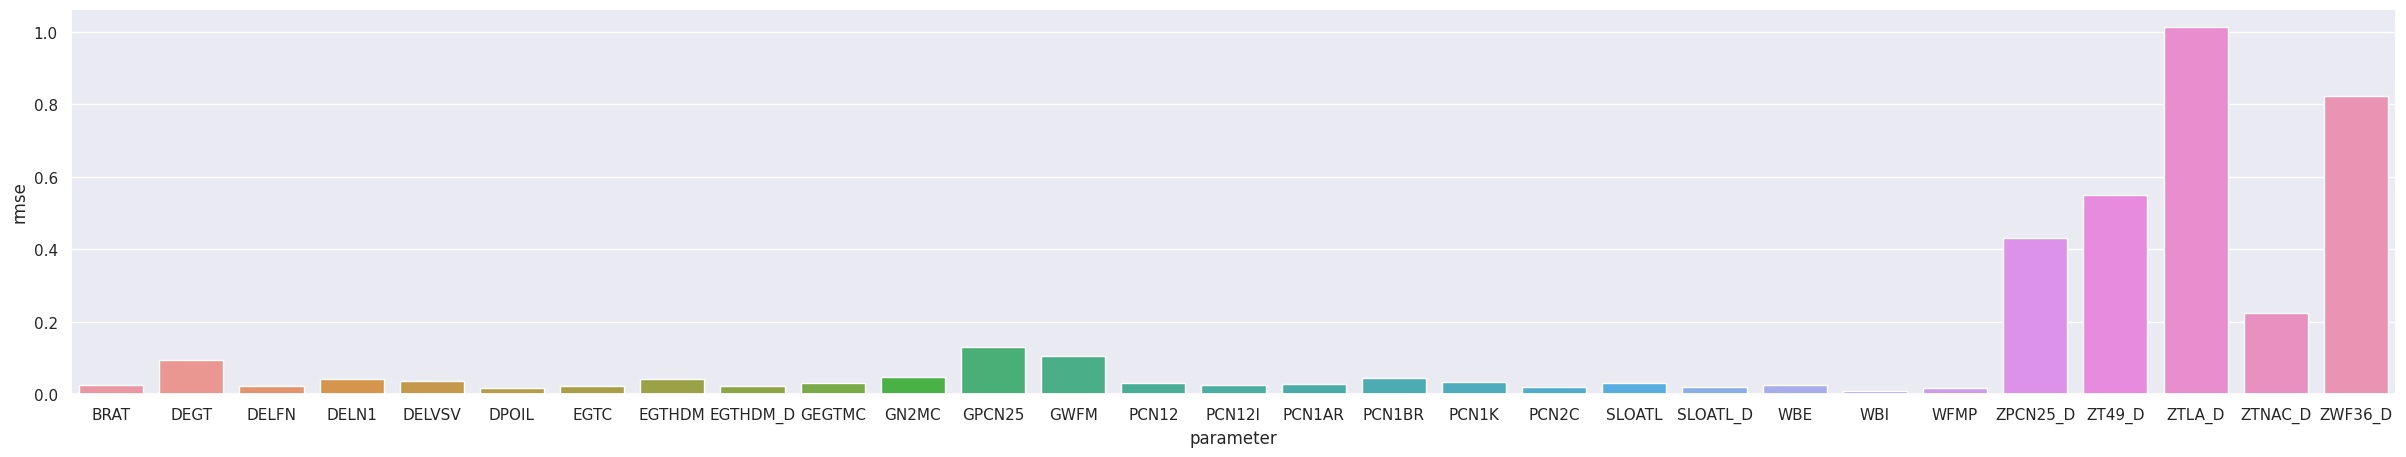

In [16]:
sns.barplot(scores, y='rmse', x='parameter')